**Notes:** 


* Indicator features in X are not scaled. Only Age is scaled.
* test/train split consists of only testing with Katniss, and excluding her observation from training.
* k-cross-validation. k set to 5.
* Scoring criterion used was accuracy (default).

# a)

In [13]:
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

RAND_SEED = 0

## Data processing

In [14]:
df = pd.read_csv('./hunger_games.csv')

### Standarizing age
According to The Hunger Games rules, contestants must be between ages 12 to 18. 
So we can standarize their ages to be in the range [0,1] as follows: 

* standard_age =(age-12)/6

Note that we will only keep 3 decimal places. 

Justification: all features are indicator variables except for age, so our model might predict better if we standarize age. 


In [15]:
# Standarize age
def standard_age(age):
    assert(age >=12)
    assert(age <= 18)
    std_age = (age-12)/6
    return float('%.3f' % std_age)

df['age'] = df['age'].apply(standard_age)

### Data cleanup

We model whether or not the players survive day 1 on several x-variables: 

* female (1 female, 0 male), 
* career (1 yes, 0 no)
* has_name (1 yes, 0 no)
* volunteer (1 yes, 0 no)
* age (standarized). 


In [16]:
# Independent variable
y = df.surv_day1
# Dependent variables/ features. throw away useless info.
features = ['female', 'career', 'has_name', 'volunteer', 'age']
X = df[features]
X.head(3)

,female,career,has_name,volunteer,age
0,0,1,1,1,0.833
1,1,1,1,1,0.833
2,0,1,1,1,1.000


### Train test split
Since we are interested in predicting Katniss, let the train set contain all the tributes except Katniss. Let the test set only contain Katniss.

Katniss corresponds to the last observation, index = 23

In [26]:
katniss_idx = 23
# Katniss features
X_test = X.iloc[katniss_idx]
y_test = y.iloc[katniss_idx]
X_train = X.drop([katniss_idx])
y_train = y.drop([katniss_idx])

## Cross validation of logistic regression with lasso penalty

In [37]:
import warnings
warnings.filterwarnings('ignore')

lambdas = [5, 3, 2.75, 2.5, 1.55, 1.5, 1.45, 1, .1, 0.05, 0.01, 0.001] 

k = 5

criterions = []
female_betas = [] 
career_betas = []
has_name_betas = []
volunteer_betas = []
age_betas = []

for i, c in enumerate(lambdas):
    lasslogreg = LogisticRegression(penalty='l1', C=1/c, solver='liblinear', random_state=RAND_SEED)
    scores = cross_val_score(lasslogreg, X_train, y_train, cv=k)
    fit = lasslogreg.fit(X_train, y_train)
    print("%0.3f accuracy criterion with stdev of %0.2f for lambda=%0.3f" % (scores.mean(), scores.std(), c))
    female_betas.append(fit.coef_[0][0])
    career_betas.append(fit.coef_[0][1])
    has_name_betas.append(fit.coef_[0][2])
    volunteer_betas.append(fit.coef_[0][3])
    age_betas.append(fit.coef_[0][4])
    criterions.append(scores.mean())

0.480 accuracy criterion with stdev of 0.07 for lambda=5.000
0.610 accuracy criterion with stdev of 0.15 for lambda=3.000
0.710 accuracy criterion with stdev of 0.20 for lambda=2.750
0.710 accuracy criterion with stdev of 0.20 for lambda=2.500
0.830 accuracy criterion with stdev of 0.15 for lambda=1.550
0.830 accuracy criterion with stdev of 0.15 for lambda=1.500
0.830 accuracy criterion with stdev of 0.15 for lambda=1.450
0.790 accuracy criterion with stdev of 0.13 for lambda=1.000
0.790 accuracy criterion with stdev of 0.13 for lambda=0.100
0.790 accuracy criterion with stdev of 0.13 for lambda=0.050
0.790 accuracy criterion with stdev of 0.13 for lambda=0.010
0.790 accuracy criterion with stdev of 0.13 for lambda=0.001


### i) Cross validated criterion as a function of lambda

Text(0.5, 1.0, 'Mean cross-validated criterion as a function of lambda')

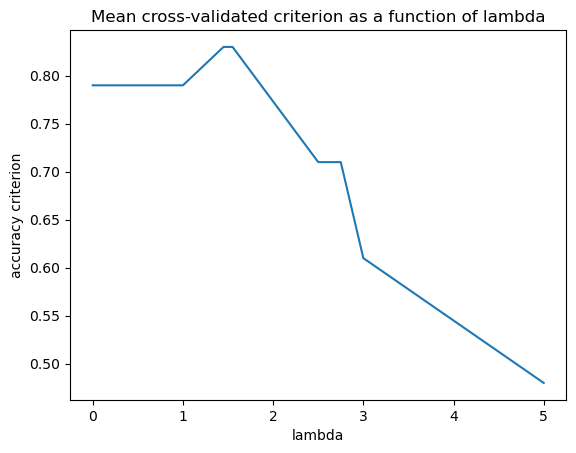

In [41]:
lambdas = np.array(lambdas)
criterions = np.array(criterions)

plt.plot(lambdas, criterions)

plt.xlabel("lambda")
plt.ylabel("accuracy criterion")
plt.title("Mean cross-validated criterion as a function of lambda")

### ii) Coefficients plot

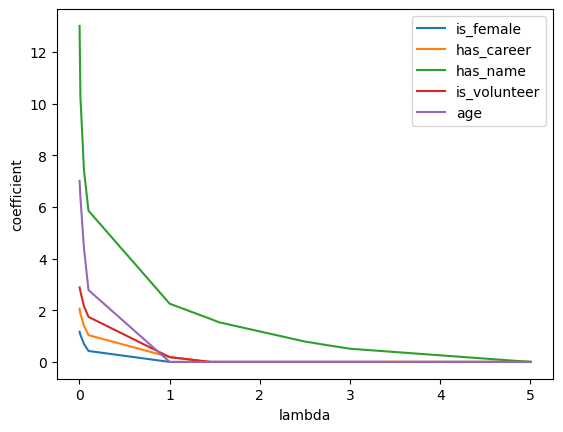

In [40]:
female_betas = np.array(female_betas)
career_betas = np.array(career_betas)
has_name_betas = np.array(has_name_betas)
volunteer_betas = np.array(volunteer_betas)
age_betas = np.array(age_betas)

plt.plot(lambdas, female_betas, label="is_female")
plt.plot(lambdas, career_betas, label="has_career")
plt.plot(lambdas, has_name_betas, label="has_name")
plt.plot(lambdas, volunteer_betas, label="is_volunteer")
plt.plot(lambdas, age_betas, label="age")

plt.xlabel("lambda")
plt.ylabel("coefficient")
plt.legend()

### iii) Which variables does the model select?

In [46]:
choice_lambda = 1.5
chosen_model = LogisticRegression(penalty='l1', solver='liblinear', C=1/choice_lambda, random_state=RAND_SEED)
chosen_fit = chosen_model.fit(X_train, y_train)

print(f"lambda = {choice_lambda}")
# This is one of the lambda values for which the cross-validation accuracy criterion is maximized so we well choose this.

print("Coefficients:")
for i, name in enumerate(features):
    print(f" beta_{name} = %.3f" % chosen_fit.coef_[0][i])

lambda = 1.5
Coefficients:
 beta_female = 0.000
 beta_career = 0.000
 beta_has_name = 1.600
 beta_volunteer = 0.000
 beta_age = 0.000


* Choice of lambda = 1.5 (corresponds to argmax for accuracy cross_validation plot)
* **Model only selects variable has_name, since it has the only non-zero coefficient**. 


# b) What are the penalized coefficients of the selected variables

* All other coefficients (**female, career, volunteer, age**) are set to zero by the lasso penalty, so they are excluded in variable selection.


# c) Given that all players with a name survive the first day, their estimate of survival probability is 100%. What is Katniss' first-day survival probability based on the Lasso model?

* Chosen fit was trained with all observations except katniss. So we use the chosen fit.
* X_test = katniss features

In [68]:
katniss = np.array(X_test).reshape(1,-1)
katniss

array([[1.   , 0.   , 1.   , 1.   , 0.667]])

In [70]:
# Prediction for katniss survival:
chosen_fit.predict_proba(katniss)

array([[0.18750194, 0.81249806]])

These probabilities correspond to Katniss belonging to classes 0 and 1 respectiveley.
So, the probability that Katniss survives the first day is **81.25%**